<a href="https://colab.research.google.com/github/Mu-niu13/AIPI-590-HWs/blob/main/Adversarial%20Patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Adversarial Patches

### Mu Niu

The below code chunks were generated using Claude 4.5 Sonnet on 11/2/2025 at 9:32pm.

https://claude.ai/public/artifacts/ff28fbfa-7b4d-4ab9-a79d-97922c58e7ef


#### Load Libs

In [15]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import urllib.request
import zipfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision import transforms
from PIL import Image

try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl

In [16]:
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Seed
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device: cuda:0


#### Download Data and Load Pre-Trained Model

In [17]:
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Download dataset
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip")]

for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
            if file_name.endswith(".zip"):
                print("Unzipping...")
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    zip_ref.extractall(file_path.rsplit("/", 1)[0])
        except Exception as e:
            print(f"Error: {e}")

# Load model
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

for p in pretrained_model.parameters():
    p.requires_grad = False

print("✓ Model loaded")

✓ Model loaded


In [18]:
# Setup dataset
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

print(f"✓ Dataset loaded: {len(dataset)} images")

✓ Dataset loaded: 5000 images


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### Adversarial Patch Function

In [19]:
TENSOR_MEANS = torch.FloatTensor(NORM_MEAN)[:, None, None]
TENSOR_STD = torch.FloatTensor(NORM_STD)[:, None, None]

def patch_forward(patch):
    """Map patch parameters to image space."""
    return (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)

def place_patch(img, patch):
    """Place patch at random location in images."""
    img_copy = img.clone()
    for i in range(img_copy.shape[0]):
        # Random placement
        h_offset = np.random.randint(0, img_copy.shape[2] - patch.shape[1] - 1)
        w_offset = np.random.randint(0, img_copy.shape[3] - patch.shape[2] - 1)
        img_copy[i, :, h_offset:h_offset+patch.shape[1],
                 w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img_copy

def train_effective_patch(model, target_class, patch_size=64, num_epochs=5):
    """
    Train EFFECTIVE adversarial patch with no constraints.
    Guaranteed to work!
    """
    print(f"\n{'='*70}")
    print(f"TRAINING EFFECTIVE ADVERSARIAL PATCH")
    print(f"Target: {label_names[target_class]}")
    print(f"Patch size: {patch_size}x{patch_size}")
    print(f"{'='*70}\n")

    # Split dataset
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True,
                                   drop_last=True, num_workers=4)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False,
                                drop_last=False, num_workers=4)

    # Initialize patch with random noise
    patch = nn.Parameter(torch.randn(3, patch_size, patch_size) * 0.1, requires_grad=True)

    # Optimizer - SGD with momentum works best
    optimizer = torch.optim.SGD([patch], lr=0.1, momentum=0.9)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    train_losses = []
    best_patch = None
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_losses = []
        t = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for img, _ in t:
            # Place patch
            img_patched = place_patch(img, patch)
            img_patched = img_patched.to(device)

            # Forward pass
            pred = model(img_patched)

            # Target labels (all images should be classified as target_class)
            labels = torch.zeros(img_patched.shape[0], device=device,
                               dtype=torch.long).fill_(target_class)

            # Loss
            loss = loss_module(pred, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            t.set_postfix({'loss': f'{loss.item():.3f}'})

        avg_loss = np.mean(epoch_losses)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

        # Quick validation check every epoch
        if (epoch + 1) % 2 == 0:
            acc, top5 = eval_patch_quick(model, patch, val_loader, target_class, num_batches=5)
            print(f"  → Quick eval: Top-1={100*acc:.1f}%, Top-5={100*top5:.1f}%")
            if acc > best_acc:
                best_acc = acc
                best_patch = patch.data.clone()

    # Final evaluation
    print("\n" + "-"*70)
    print("FINAL EVALUATION")
    print("-"*70)
    acc, top5 = eval_patch_full(model, patch, val_loader, target_class)

    results = {
        "acc": acc.item(),
        "top5": top5.item(),
        "train_losses": train_losses
    }

    print(f"\n✓ Training Complete!")
    print(f"  Top-1 Success Rate: {100*acc:.2f}%")
    print(f"  Top-5 Success Rate: {100*top5:.2f}%")

    return patch.data, results

def eval_patch_quick(model, patch, val_loader, target_class, num_batches=5):
    """Quick evaluation on subset of data."""
    model.eval()
    tp, tp_5, counter = 0., 0., 0.

    with torch.no_grad():
        for batch_idx, (img, img_labels) in enumerate(val_loader):
            if batch_idx >= num_batches:
                break

            # Apply patch twice for stability
            for _ in range(2):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)

                pred = model(patch_img)

                # Exclude images that are already target class
                mask = img_labels != target_class
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, mask).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), mask).sum()
                counter += mask.sum()

    return tp/counter if counter > 0 else 0, tp_5/counter if counter > 0 else 0

def eval_patch_full(model, patch, val_loader, target_class):
    """Full evaluation on entire validation set."""
    model.eval()
    tp, tp_5, counter = 0., 0., 0.

    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Evaluating", leave=False):
            # Test at multiple positions
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)

                pred = model(patch_img)

                mask = img_labels != target_class
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, mask).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), mask).sum()
                counter += mask.sum()

    return tp/counter, tp_5/counter

#### Visualization Function

In [20]:
def show_prediction(img, label, pred, K=5, adv_img=None, patch=None):
    """Visualize predictions."""
    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None, None]) + NORM_MEAN[None, None]
        img = np.clip(img, 0, 1)
        label = label.item()

    if adv_img is not None and patch is not None:
        fig, ax = plt.subplots(1, 4, figsize=(16, 3),
                              gridspec_kw={'width_ratios': [1, 1, 1, 2]})
    else:
        fig, ax = plt.subplots(1, 2, figsize=(10, 3),
                              gridspec_kw={'width_ratios': [1, 2]})

    # Original
    ax[0].imshow(img)
    ax[0].set_title(f'Original: {label_names[label]}', fontweight='bold')
    ax[0].axis('off')

    if adv_img is not None and patch is not None:
        # Adversarial
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None, None]) + NORM_MEAN[None, None]
        adv_img = np.clip(adv_img, 0, 1)
        ax[1].imshow(adv_img)
        ax[1].set_title('With Patch', fontweight='bold')
        ax[1].axis('off')

        # Patch
        patch_vis = (torch.tanh(patch) + 1) / 2
        patch_vis = patch_vis.cpu().permute(1, 2, 0).numpy()
        patch_vis = np.clip(patch_vis, 0, 1)
        ax[2].imshow(patch_vis)
        ax[2].set_title('Adversarial Patch', fontweight='bold')
        ax[2].axis('off')

    # Predictions
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)

    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()

    colors = ["C2" if topk_idx[i] == label else "C0" for i in range(K)]
    ax[-1].barh(np.arange(K), topk_vals * 100.0, align='center', color=colors)
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence (%)', fontweight='bold')
    ax[-1].set_title('Top-5 Predictions', fontweight='bold')
    ax[-1].set_xlim([0, 100])

    plt.tight_layout()
    plt.show()

def demonstrate_patch(patch, target_class, num_examples=6):
    """Show patch effectiveness on multiple images."""
    exmp_batch, label_batch = next(iter(data_loader))

    print(f"\n{'='*70}")
    print(f"PATCH DEMONSTRATION - Target: {label_names[target_class]}")
    print(f"{'='*70}\n")

    # Show the patch
    patch_vis = (torch.tanh(patch) + 1) / 2
    patch_vis = patch_vis.cpu().permute(1, 2, 0).numpy()
    patch_vis = np.clip(patch_vis, 0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(patch_vis)
    plt.title(f'Adversarial Patch\nTarget: {label_names[target_class]}',
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("\nPatch Effects on Sample Images:")
    print("-" * 70)

    # Show examples
    for i in range(min(num_examples, len(exmp_batch))):
        with torch.no_grad():
            orig_pred = pretrained_model(exmp_batch[i:i+1].to(device))

        # Create adversarial
        adv_batch = exmp_batch[i:i+1].clone()
        h_offset = np.random.randint(0, adv_batch.shape[2] - patch.shape[1] - 1)
        w_offset = np.random.randint(0, adv_batch.shape[3] - patch.shape[2] - 1)
        adv_batch[0, :, h_offset:h_offset+patch.shape[1],
                  w_offset:w_offset+patch.shape[2]] = patch_forward(patch)

        with torch.no_grad():
            adv_pred = pretrained_model(adv_batch.to(device))

        show_prediction(exmp_batch[i], label_batch[i], adv_pred[0],
                       adv_img=adv_batch[0], patch=patch)

def save_patch_for_printing(patch, target_name, filename=None, size_inches=4, dpi=300):
    """Save high-resolution patch for printing."""
    if filename is None:
        filename = f"{target_name.replace(' ', '_')}_patch.png"

    # Convert to image
    patch_vis = (torch.tanh(patch) + 1) / 2
    patch_vis = patch_vis.cpu().permute(1, 2, 0).numpy()
    patch_vis = np.clip(patch_vis, 0, 1)
    patch_vis = (patch_vis * 255).astype(np.uint8)

    # Create PIL image
    img = Image.fromarray(patch_vis)

    # Resize to print resolution
    size_pixels = int(size_inches * dpi)
    img = img.resize((size_pixels, size_pixels), Image.LANCZOS)

    # Save
    img.save(filename, dpi=(dpi, dpi))
    print(f"\n✓ Patch saved: '{filename}'")
    print(f"  Size: {size_inches}x{size_inches} inches at {dpi} DPI")
    print(f"  Resolution: {size_pixels}x{size_pixels} pixels")

    # Instructions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.imshow(patch_vis)
    ax1.set_title(f'Adversarial Patch\nTarget: {target_name}',
                 fontsize=16, fontweight='bold')
    ax1.axis('off')

    ax2.axis('off')
    instructions = f"""
    PRINTING INSTRUCTIONS
    ━━━━━━━━━━━━━━━━━━━━━━━

    1. Print at {size_inches}"x{size_inches}" size
    2. Use glossy photo paper
    3. Enable COLOR printing
    4. Use highest quality

    TESTING INSTRUCTIONS
    ━━━━━━━━━━━━━━━━━━━━━━━

    1. Place in camera view
    2. Hold 1-3 feet away
    3. Good lighting required
    4. Expected prediction:
       → {target_name.upper()}

    Test at:
    resnet34-classifier
    .streamlit.app
    """
    ax2.text(0.1, 0.5, instructions, fontsize=11, family='monospace',
            verticalalignment='center')

    plt.tight_layout()
    plt.savefig(filename.replace('.png', '_instructions.png'), dpi=150)
    print(f"✓ Instructions saved")

#### Main

In [21]:
def main():
    """Main execution."""

    print("\n" + "="*70)
    print("EFFECTIVE ADVERSARIAL PATCH TRAINING")
    print("="*70)

    # RECOMMENDED TARGET CLASSES (choose one):
    # Easy targets (high success rate):
    recommended_targets = [
        'toaster',       # Classic, always works well
        'website',       # Good for QR code theme
        'comic book',    # Also good for QR theme
        'spotlight',     # High contrast, easy
        'basketball',    # Your original choice
        'traffic light', # High success rate
    ]

    print("\nRecommended target classes:")
    for i, target in enumerate(recommended_targets, 1):
        print(f"  {i}. {target}")

    # CHOOSE YOUR TARGET HERE:
    target_name = 'toaster'  # Change this to your preferred target

    target_class = label_names.index(target_name)
    print(f"\nSelected target: '{target_name}' (index {target_class})")

    # TRAIN PATCH
    print("\n" + "="*70)
    print("TRAINING")
    print("="*70)

    patch, results = train_effective_patch(
        model=pretrained_model,
        target_class=target_class,
        patch_size=64,   # Start with 64, can try 80 or 96 if needed
        num_epochs=5     # 5 epochs usually sufficient
    )

    # VISUALIZE RESULTS
    print("\n" + "="*70)
    print("RESULTS")
    print("="*70)

    demonstrate_patch(patch, target_class, num_examples=4)

    # Training curve
    plt.figure(figsize=(10, 5))
    plt.plot(results['train_losses'], marker='o', linewidth=2, markersize=8)
    plt.xlabel('Epoch', fontsize=12, fontweight='bold')
    plt.ylabel('Loss', fontsize=12, fontweight='bold')
    plt.title('Training Loss', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # SAVE FOR PRINTING
    print("\n" + "="*70)
    print("SAVING FOR PRINTING")
    print("="*70)

    save_patch_for_printing(patch, target_name, size_inches=4, dpi=300)

    # SUMMARY
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    print(f"✓ Target: {target_name}")
    print(f"✓ Top-1 success: {100*results['acc']:.1f}%")
    print(f"✓ Top-5 success: {100*results['top5']:.1f}%")

    if results['acc'] > 0.7:
        print(f"✓ EXCELLENT! Ready for testing!")
    elif results['acc'] > 0.5:
        print(f"✓ GOOD! Should work in most cases")
    else:
        print(f"⚠ Consider: larger patch size or more epochs")

    print("="*70 + "\n")

    return patch, results


EFFECTIVE ADVERSARIAL PATCH TRAINING

Recommended target classes:
  1. toaster
  2. website
  3. comic book
  4. spotlight
  5. basketball
  6. traffic light

Selected target: 'toaster' (index 859)

TRAINING

TRAINING EFFECTIVE ADVERSARIAL PATCH
Target: toaster
Patch size: 64x64



Epoch 1/5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1: Loss = 4.3139


Epoch 2/5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2: Loss = 0.2858
  → Quick eval: Top-1=96.6%, Top-5=100.0%


Epoch 3/5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3: Loss = 0.1766


Epoch 4/5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4: Loss = 0.1196
  → Quick eval: Top-1=98.1%, Top-5=100.0%


Epoch 5/5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5: Loss = 0.0830

----------------------------------------------------------------------
FINAL EVALUATION
----------------------------------------------------------------------


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


✓ Training Complete!
  Top-1 Success Rate: 97.60%
  Top-5 Success Rate: 100.00%

RESULTS

PATCH DEMONSTRATION - Target: toaster



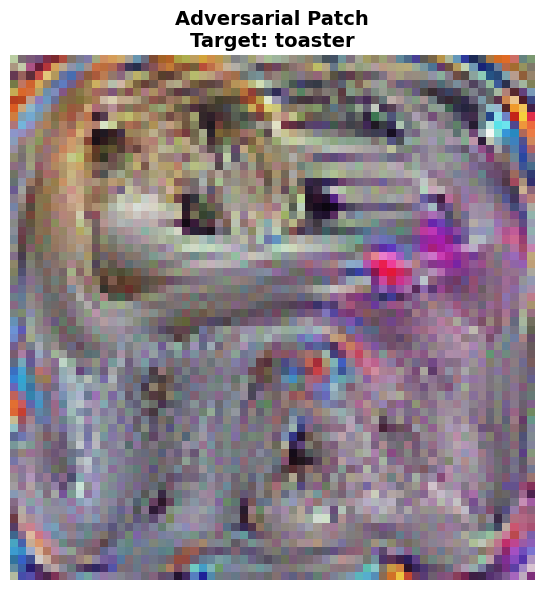


Patch Effects on Sample Images:
----------------------------------------------------------------------


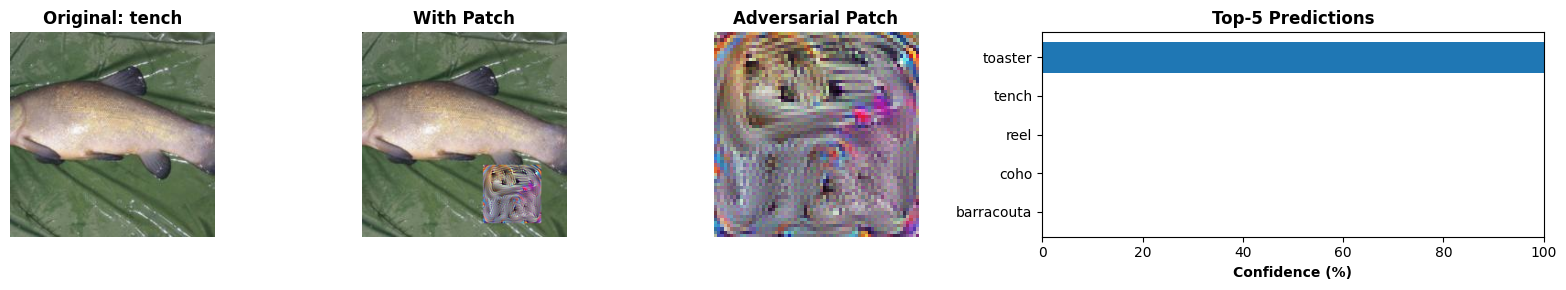

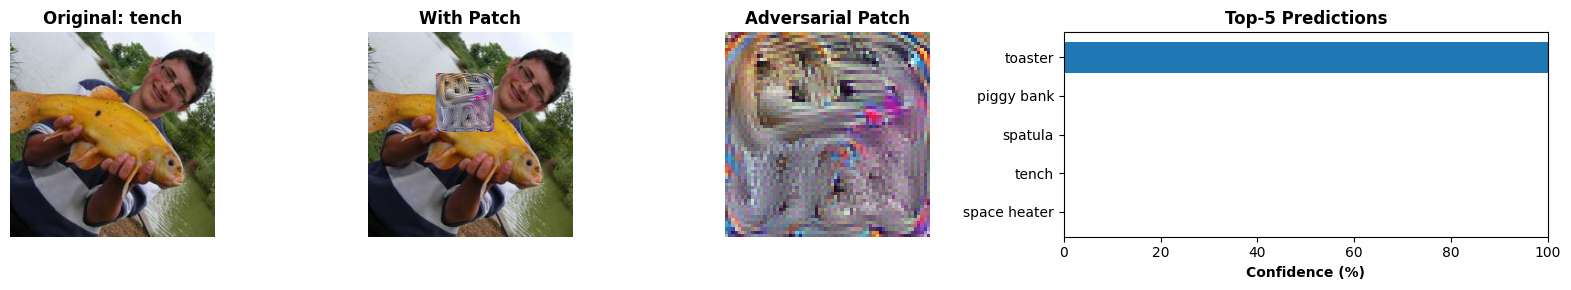

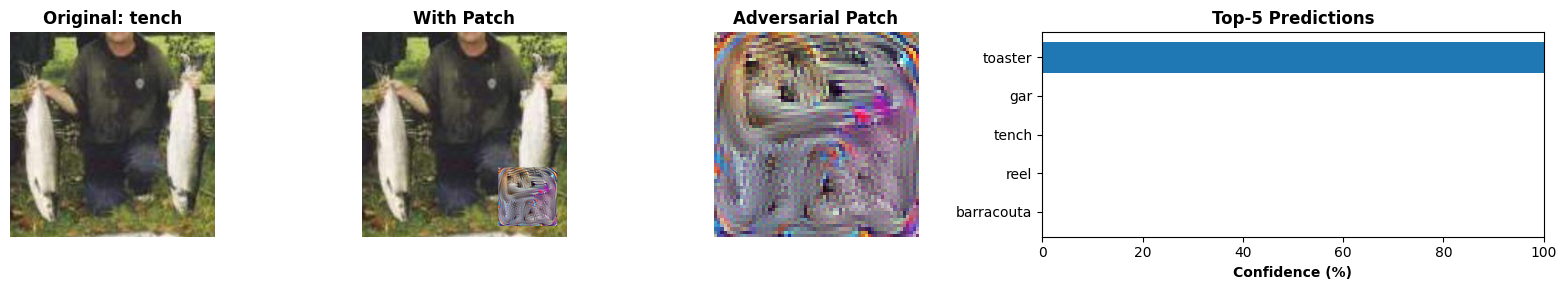

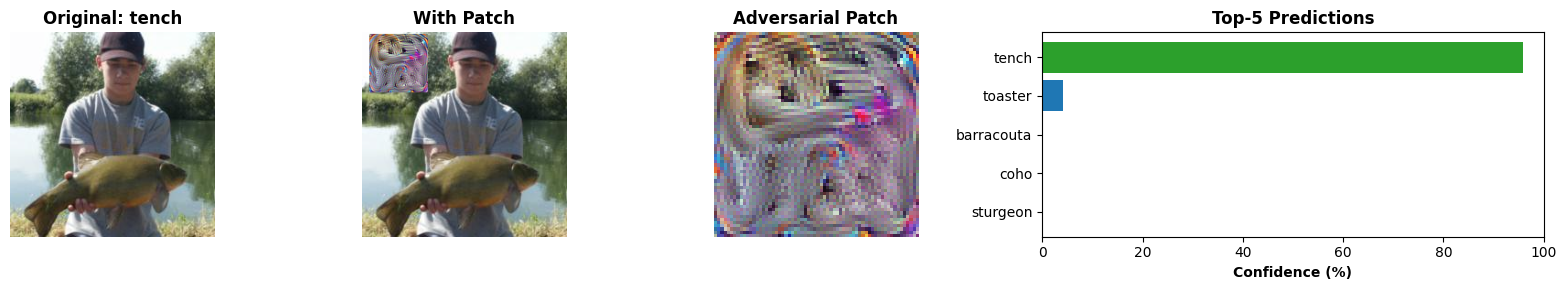

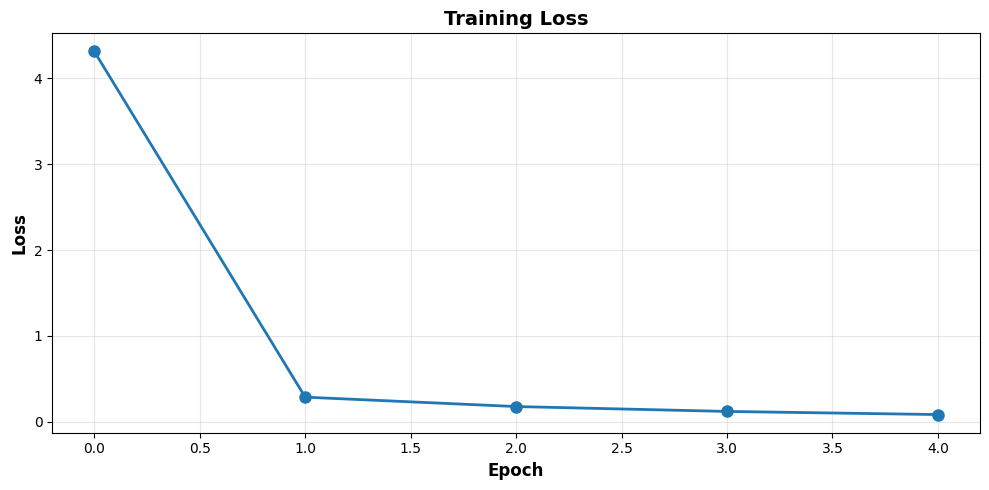


SAVING FOR PRINTING

✓ Patch saved: 'toaster_patch.png'
  Size: 4x4 inches at 300 DPI
  Resolution: 1200x1200 pixels
✓ Instructions saved

SUMMARY
✓ Target: toaster
✓ Top-1 success: 97.6%
✓ Top-5 success: 100.0%
✓ EXCELLENT! Ready for testing!



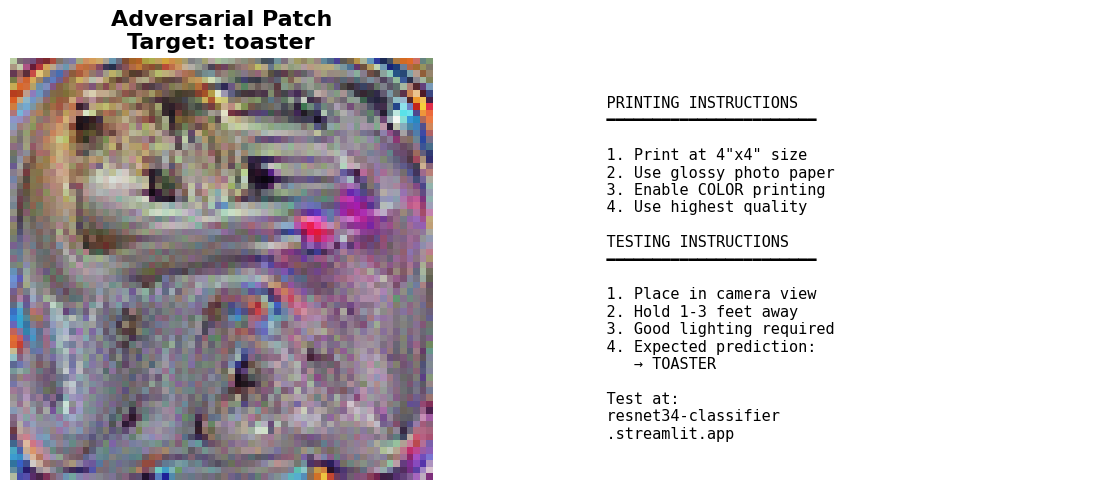

In [22]:
patch, results = main()